# Построение модели для задачи классификации

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана.

Нужно построить модель с максимально большим значением accuracy. Таргетное значение нужно довести о крайней мере до 0.75. Требуется проверить accuracy на тестовой выборке.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- сalls — количество звонков;
- minutes — суммарная длительность звонков в минутах;
- messages — количество sms-сообщений;
- mb_used — израсходованный интернет-трафик в Мб;
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

<a id="Задачи_исследования"></a>

## Задачи исследования

- #### [Этап 1. Загрузите файл с данными и изучите его;](#Этап_1)

- #### [Этап 2. Разделите исходные данные на обучающую, валидационную и тестовую выборки;](#Этап_2)

- #### [Этап 3. Исследуйте качество разных моделей, меняя гиперпараметры:](#Этап_3)

    - ##### [Логистическая регрессия (Logistic Regression);](#Logistic_Regression)
    - ##### [Решающие деревья (Decision Trees);](#Decision_Trees)
    - ##### [Случайный лес (Random Forest);](#Random_Forest)
    - ##### [Градиентный бустинг (Gradient Boosting).](#Gradient_Boosting)



- #### [Этап 4. Проверьте качество модели на тестовой выборке;](#Этап_4)

- #### [Этап 5. Проверьте модели на вменяемость.](#Этап_5)

<a id="Этап_1"></a>

## Этап 1: Загрузить и изучить данные
#### Подключение библиотек

[Вернуться к задачам исследования](#Задачи_исследования)

In [ ]:
import pandas as pd                                            # Библиотека для работы с данными, предоставляет функции и структуры данных, такие как DataFrame и Series.
import numpy as np                                             # Фундаментальная библиотека для научных вычислений с поддержкой многомерных массивов и матриц.
import warnings                                                # Модуль для управления предупреждениями.
import random                                                  # Импорт модуля для генерации случайных чисел

import statsmodels.api as sm                                                # statsmodels.api используется для оценки статистических моделей
from statsmodels.stats.outliers_influence import variance_inflation_factor  # variance_inflation_factor из statsmodels используется для определения мультиколлинеарности

# Модули для работы с машинным обучением
from sklearn.model_selection import train_test_split           # Инструмент библиотеки sklearn для разделения исходных данных на обучающую, валидационную и тестовую выборку.
from sklearn.model_selection import learning_curve             # Инструмент для построения кривых обучения.
from sklearn.model_selection import GridSearchCV               # Инструмент для выполнения поиска по сетке параметров модели.
from sklearn.linear_model    import LogisticRegression         # Модель логистической регрессии.
from sklearn.tree            import DecisionTreeClassifier     # Модель дерева решений.
from sklearn.ensemble        import RandomForestClassifier     # Модель случайного леса.
from sklearn.ensemble        import GradientBoostingClassifier # Модель градиентного бустинга.
from sklearn.metrics         import accuracy_score             # Метрика - точность классификации.
from sklearn.metrics         import confusion_matrix           # Метрика - матрица неточностей.
from sklearn.metrics         import roc_curve, roc_auc_score   # Метрики - ROC-кривая и ROC AUC Score.
from sklearn.dummy           import DummyClassifier            # Базовые моедли на проверки на вменяемость

# Визуализация данных
import matplotlib.pyplot as plt                                # Библиотека для визуализации данных.
import seaborn as sns                                          # Библиотека для красивой визуализации статистических данных.


# Настрйоки отображения
# Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.display.float_format = '{:.2f}'.format

# Устанавливает фильтр предупреждений
warnings.filterwarnings("ignore")

random_state = random.seed(1729)                               # Пасхалка с числом

#### Загрузка данных из файла

In [ ]:
try:
    df = pd.read_csv('/Users/Edward/Code/DS+/csv/users_behavior.csv', sep = ',')
except:
    df = pd.read_csv('/datasets/users_behavior.csv', sep = ',')

#### Изучение данных из файлов

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


In [ ]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,19915.42,0
1,85.00,516.75,56.00,22696.96,0
2,77.00,467.66,86.00,21060.45,0
3,106.00,745.53,81.00,8437.39,1
4,66.00,418.74,1.00,14502.75,0


In [ ]:
# Подсчитываем количество объектов для каждого класса
class_counts = df['is_ultra'].value_counts()

# Выводим результаты
print(class_counts)

0    2229
1     985
Name: is_ultra, dtype: int64


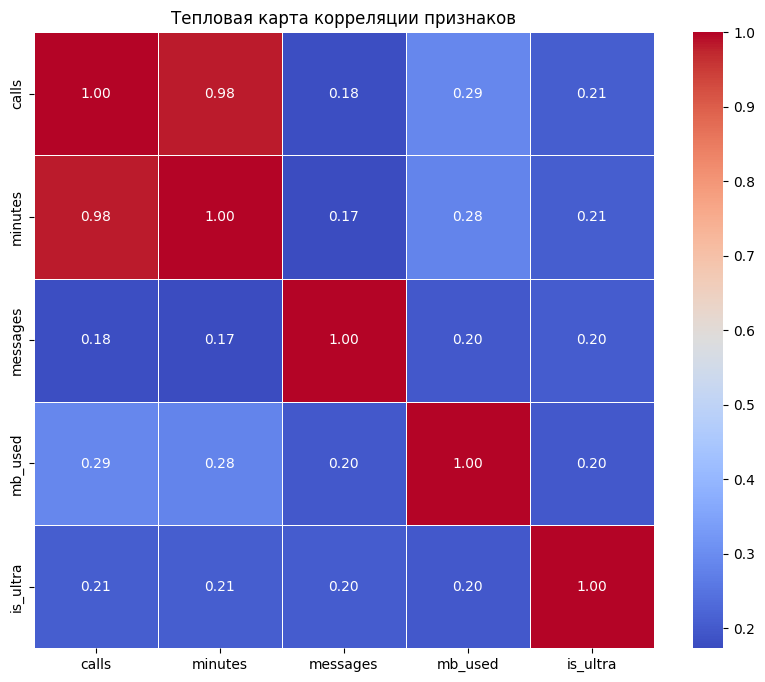

In [ ]:
# Вычисляем корреляцию признаков
correlation_matrix = df.corr()

# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта корреляции признаков')
plt.show()

### Исследуем Мультиколлинеарность

Мультиколлинеарность - это явление, при котором два или более признака взаимно связаны друг с другом, что может вызвать проблемы при построении модели. Два основных типа проблем, связанных с мультиколлинеарностью:

- Затруднение интерпретации коэффициентов: Когда мультиколлинеарность присутствует, сложно определить точный вклад каждого признака в предсказание, так как их эффекты смешиваются между собой;

- Неустойчивость коэффициентов: Малейшие изменения в данных могут привести к значительным изменениям коэффициентов модели, что делает результаты менее надежными и устойчивыми;

- Мультиколлинеарность может быть особенно проблематичной для некоторых моделей, таких как линейная регрессия, логистическая регрессия и некоторые другие алгоритмы, которые используют линейную комбинацию признаков.

In [ ]:
# Выделяем независимые переменные (признаки)
X = df.drop(columns=['is_ultra'])

# Добавляем константу для использования модуля statsmodels
X_with_const = sm.add_constant(X)

# Создаем объект регрессии
model = sm.OLS(df['is_ultra'], X_with_const)

# Обучяем модель
result = model.fit()

# Рассчитываем VIF для каждого признака
vif = pd.DataFrame()
vif['Feature'] = X_with_const.columns
vif['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Выводим результаты
print(vif)

    Feature   VIF
0     const  8.07
1     calls 28.28
2   minutes 28.16
3  messages  1.06
4   mb_used  1.12


### Вывод

- Модель готова к обучению;

- Классы не сбалансированы, так как количество объектов в каждом классе значительно отличается. Класс "Смарт" (0) имеет 2229 объектов, в то время как класс "Ультра" (1) имеет всего 985 объектов;

- Анализ VIF показал, что признаки 'calls' и 'minutes' сильно коррелируют между собой, что может быть проблемой для построения модели из-за мультиколлинеарности. Остальные признаки (messages и mb_used) показали низкую мультиколлинеарность, что может быть полезным для стабильности и интерпретации модели.

    Возможные решения: Использование методов регуляризации. В линейной регрессии мы можем использовать методы регуляризации, такие как L1 (Lasso) или L2 (Ridge) регуляризация, которые штрафуют большие значения коэффициентов, что может уменьшить влияние мультиколлинеарности.

<a id="Этап_2"></a>

### Этап 2. Разделим исходные данные на обучающую и тестовую выборку

[Вернуться к задачам исследования](#Задачи_исследования)

Мы будем исполльзовать GridSearchCV, следовательно внутри будет происходить  кросс-валидация, которая включает разделение данных на обучающую и валидационную выборки. Это позволяет оценить производительность модели на различных подмножествах данных и выбрать оптимальные гиперпараметры. Нам достаточно разделить выборку на обучающую и тестоваю.

- X_train, y_train - обучающая выборка;
- X_test, y_test - тестовая выборка.

In [ ]:
# X используем для обозначения признаков (features)
# y используем для обозначения целевой переменной (target)
X_features = df.drop(['is_ultra'], axis = 1)
y_target = df['is_ultra']

# Разделение данных на обучающую и тестовую выборку (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0, stratify=y_target)

## Вывод

- Мы использовали функцию train_test_split из библиотеки scikit-learn для разделения данных на обучающую и тестовую выборки. Это поможет объективно оценить качество модели, избежать переобучения и обеспечить репрезентативность выборок;

- Установили random_state = random.seed(1729) для контроля вариабельности и воспроизводимости результатов при каждом запуске кода;

- Использовали понятные переменные X_features и y_target, что улучшило читаемость кода и понимание логики разделения данных;

- Подход соответствует общепринятым практикам машинного обучения, обеспечивая актуальность и надежность;

- Оптимально разделили выборки в соотношении 80%-20% для тестовой и обучающей, обеспечивает адекватное количество данных для обучения и тестирования модели.

<a id="Этап_3"></a>

### Этап 3. Исследуем качество разных моделей, меняя гиперпараметры.

[Вернуться к задачам исследования](#Задачи_исследования)

<a id="Logistic_Regression"></a>

#### Логистическая регрессия (Logistic Regression)

Логистическая регрессия - это один из основных алгоритмов машинного обучения, который используется для решения задач классификации. Она относится к семейству линейных моделей, где целевая переменная является дискретной и принимает значения из заданного множества классов.

Идея логистической регрессии заключается в том, чтобы найти оптимальные веса (коэффициенты) для каждого признака, чтобы прогнозировать вероятность принадлежности объекта к определенному классу. Основной принцип заключается в применении логистической функции (также называемой сигмоидой) для преобразования линейной комбинации признаков в вероятности.

Обучение модели логистической регрессии выполняется с использованием метода максимального правдоподобия (maximum likelihood estimation).

Вот как это работает:


#### 1) Модель логистической регрессии:

В логистической регрессии модель представляется следующим уравнением:

* ##### $y = sigmoid(w^T * x + b)$

где:
- $y$ - бинарный выход (0 или 1, обозначающий классы);
- $w$ - вектор весов (коэффициентов) для каждого признака;
- $x$ - вектор признаков объекта;
- $b$ - смещение (bias).

#### Что такое sigmoid?
 sigmoid - это математическая функция сигмоиды, которая часто используется в машинном обучении, особенно в логистической регрессии и нейронных сетях. Она принимает любое вещественное число и отображает его в интервал между 0 и 1.

 - $sigma(x) = \frac {1}{(1 + exp(-x))}$

 В логистической регрессии функция линейной регрессии подставляется в качестве аргумента для функции сигмоиды (или логистической функции).

#### 2) Логистическая функция потерь:

Для задач классификации с двумя классами, используется логистическая функция потерь (логарифмическая функция правдоподобия):
* ##### $Loss = - \frac {1}{n} * Σ(y_i * log(p_i) + (1 - y_i) * log(1 - p_i))$

где:
- $n$ - количество образцов в обучающем наборе;
- $y_i$ - истинный класс для i-го образца (0 или 1);
- $p_i$ - предсказанная вероятность принадлежности к классу 1 для i-го образца.

Чем логистическая функция потерь меньше, тем лучше модель предсказывает исходы на обучающем наборе данных. Минимизация функции потерь является целью оптимизационного процесса и указывает на то, что модель делает меньше ошибок в прогнозировании меток классов.

Чем функция правдоподобия больше, тем лучше модель описывает наблюдаемые данные. Максимизация функции правдоподобия означает, что вероятность генерации наблюдаемых данных моделью максимальна, что в свою очередь указывает на хорошую подгонку модели к данным.

В обоих случаях, однако, важно помнить о риске переобучения: если модель слишком хорошо подгоняется под тренировочные данные (то есть функция потерь очень маленькая или функция правдоподобия очень большая), она может потерять способность к обобщению на новые, неизвестные данные.

#### 3) Оптимизация весов:

Задача состоит в нахождении такого набора весов $(w)$ и смещения $(b)$, которые минимизируют функцию потерь. Для этого обычно используют методы оптимизации, такие как градиентный спуск, чтобы найти глобальный минимум функции потерь.

#### 4) Прогноз:

После завершения процесса обучения, модель готова для прогнозирования новых данных. Она использует найденные оптимальные веса и смещение, чтобы вычислить вероятность принадлежности к классу 1 для новых объектов. Если вероятность больше некоторого порогового значения (обычно 0.5), объект относится к классу 1, иначе - к классу 0.

In [ ]:
# Определение модели логистической регрессии
model = LogisticRegression(random_state = random_state)

"""Определение сетки гиперпараметров, которые будут исследоваться при подборе оптимальных значений.

'penalty': ['l1', 'l2']
Гиперпараметр, определяющий тип регуляризации.
'l1': L1-регуляризация (также известная как LASSO) добавляет штрафы на абсолютные значения весов признаков.
'l2': L2-регуляризация (также известная как Ridge) добавляет штрафы на квадраты весов признаков.

'C': [0.01, 0.1, 1, 10, 100]
Гиперпараметр, определяющий обратную силу регуляризации.
C - обратная величина коэффициента регуляризации. Большее значение C уменьшает силу регуляризации,
что может привести к более сложной модели, подгоняющейся под обучающие данные.

'solver': ['liblinear', 'lbfgs']
Гиперпараметр, определяющий алгоритм оптимизации, используемый при обучении модели.
'liblinear': Итерационный метод, основанный на методе координатного спуска. Подходит для регуляризации 'l1'.
'lbfgs': Метод оптимизации Broyden-Fletcher-Goldfarb-Shanno, подходит для регуляризации 'l2'.

'max_iter': [100, 200, 300]
Гиперпараметр, определяющий максимальное количество итераций для сходимости алгоритма оптимизации.
Задает максимальное число итераций, которое алгоритм может выполнять при обучении модели.
Большее значение может быть полезно, если модель сходится медленно."""

# Определение сетки гиперпараметров, которую нужно исследовать
param_grid = {
    'penalty': ['l1', 'l2'],              # тип регуляризации (L1 или L2)
    'C': [0.01, 0.1, 1, 10, 100],         # обратная сила регуляризации
    'solver': ['liblinear', 'lbfgs'],     # алгоритм оптимизации (изменил lbfgs на liblinear)
    'max_iter': [100, 200, 300],          # максимальное количество итераций
}

# Создание экземпляра GridSearchCV с 10 фолдами кросс-валидации и оптимизацией по accuracy
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', refit=True)

# Обучение на обучающей выборке с перебором всех комбинаций гиперпараметров
grid_search.fit(X_train, y_train)

# Получение лучшей модели с оптимальными гиперпараметрами
best_model = grid_search.best_estimator_

# Лучшая оценка (метрика accuracy) на валидационных данных
best_accuracy = grid_search.best_score_
print("Лучшая оценка на валидационных данных (accuracy):", best_accuracy)

Лучшая оценка на валидационных данных (accuracy): 0.7498974451784152


In [ ]:
# Оценка модели на тестовой выборке
test_accuracy = best_model.score(X_test, y_test)
print("Точность на тестовой выборке:", test_accuracy)

Точность на тестовой выборке: 0.7480559875583204


### Матрица ошибок (confusion matrix):
Показывает число правильно и неправильно классифицированных примеров. Хорошо для визуального понимания производительности модели.

In [ ]:
def display_confusion_matrix(y_true, y_pred, model_name):
    """
    Визуализирует и отображает матрицу ошибок для заданной модели.

    Параметры:
    y_true : array-like
        Верные (истинные) метки.
    y_pred : array-like
        Предсказанные метки, как возвращено классификатором.
    model_name : string
        Название модели, используется для заголовка графика и в выводе информации.

    Возвращает:
    None
    """

    # Получение матрицы ошибок
    cm = confusion_matrix(y_true, y_pred)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(10,7))

    # Отображаем информацию о каждом квадрате
    labels = ['Истинно отрицательные (TN)', 'Ложноположительные (FP)', 'Ложноотрицательные (FN)', 'Истинноположительные (TP)']
    labels = np.asarray(labels).reshape(2,2)

    # Расчет процентного соотношения
    cm_sum = np.sum(cm)
    cm_perc = cm / cm_sum * 100

    # Создание тепловой карты
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Матрица ошибок для {model_name}')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')

    ax = plt.gca()

    # Добавление меток
    for i in range(2):
        for j in range(2):
            ax.text(j+0.5, i+0.6, '{}\n({:.2f}%)'.format(labels[i, j], cm_perc[i, j]),
                    ha='center', va='center')

    plt.show()

    # Вывод текстового результата
    tn, fp, fn, tp = cm.ravel()
    tn_perc, fp_perc, fn_perc, tp_perc = cm_perc.ravel()

    print(f"Истинно отрицательные (TN): {tn} ({tn_perc:.2f}%)")
    print(f"Ложноположительные    (FP): {fp} ({fp_perc:.2f}%)")
    print(f"Ложноотрицательные    (FN): {fn} ({fn_perc:.2f}%)")
    print(f"Истинноположительные  (TP): {tp} ({tp_perc:.2f}%)")


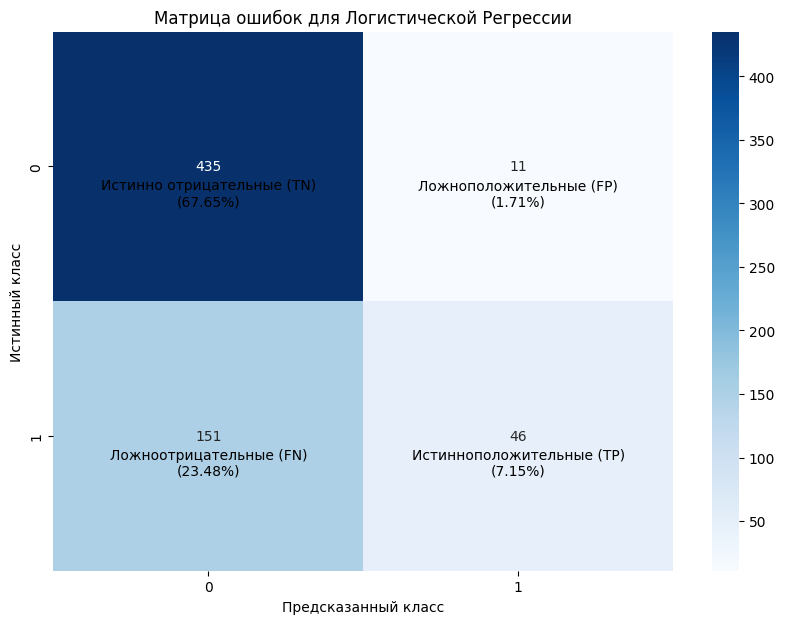

Истинно отрицательные (TN): 435 (67.65%)
Ложноположительные    (FP): 11 (1.71%)
Ложноотрицательные    (FN): 151 (23.48%)
Истинноположительные  (TP): 46 (7.15%)


In [ ]:
# Прогнозирование на тестовой выборке
y_val_pred = best_model.predict(X_test)

# Вызов функции для отображения матрицы ошибок
display_confusion_matrix(y_test, y_val_pred, "Логистической Регрессии")

## На основе TN, FP, FN, TP можно рассчитать дополнительные метрики для оценки производительности модели:

### Accuracy (Точность)

Точность – это самая интуитивная метрика и измеряет долю правильных предсказаний среди всех предсказаний. Она рассчитывается по формуле:

 - ${Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$

Точность хорошо работает только тогда, когда классы сбалансированы, то есть количество примеров каждого класса примерно одинаково.

### Precision (Точность предсказания)

Точность предсказания показывает, какая доля объектов, отнесённых к положительному классу, действительно является положительным. Эта метрика полезна, когда стоимость ложноположительных результатов высока. Формула для её расчёта:

 - ${Precision} = \frac{TP}{TP + FP}$

### Recall (Полнота)

Полнота измеряет, какую долю объектов реального положительного класса модель смогла обнаружить. Эта метрика важна, когда важно не упустить объекты положительного класса. Формула для полноты:

 - ${Recall} = \frac{TP}{TP + FN}$

### F1 Score

F1 Score – это гармоническое среднее точности и полноты. Эта метрика стремится уравновесить точность и полноту, она будет высокой только если обе метрики высоки. F1 Score особенно полезен, когда распределение классов несбалансировано. Формула для F1 Score:

 - ${F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

Эти метрики используются для оценки качества классификационных моделей и помогают выбрать наилучшую модель для конкретной задачи, в зависимости от того, какие ошибки более критичны для этой задачи — ложноположительные или ложноотрицательные.

### Выводы:

- Модель имеет высокую способность правильно предсказывать пользователей с тарифом "Смарт" (класс "0"), что подтверждают высокие значения истинно отрицательных (TN) и низкие значения ложноположительных (FP) результатов;

- Однако модель показывает низкую способность правильно определять пользователей с тарифом "Ультра" (класс "1"), что указывают на высокие значения ложноотрицательных (FN) результатов.

### Кривые обучения (learning curves):

Показывают, как изменяется ошибка на тренировочном и валидационном наборах в процессе обучения.
Хороши для идентификации переобучения или недообучения.

In [ ]:
def display_learning_curves(model, X, y, cv):
    """
    Вычисляет и отображает кривые обучения для заданной модели.

    Параметры:
    model : object
        Обученная модель.
    X : array-like
        Признаки для обучения модели.
    y : array-like
        Целевая переменная для обучения модели.
    cv : int
        Количество блоков в кросс-валидации.

    Возвращает:
    None
    """

    # Вычисление кривых обучения
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=cv)

    # Усреднение оценок на тренировочной и валидационной выборках
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    # Вычисление стандартного отклонения на тренировочной и валидационной выборках
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Визуализация кривых обучения
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, train_scores_mean, label='Точность на тренировочной выборке')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2)
    plt.plot(train_sizes, val_scores_mean, label='Точность на кросс валидационной выборке')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2)

    # Добавление элементов на график
    plt.title('Кривые обучения')
    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('Оценка')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

    # Точность на тренировочной выборке
    print("Точность на тренировочной выборке:")
    for size, score, std in zip(train_sizes, train_scores_mean, train_scores_std):
        print(f"Размер выборки: {size}, Точность: {score:.2f} +/- {std:.2f}")

    # Точность на кросс-валидационной выборке
    print("\nТочность на кросс-валидационной выборке:")
    for size, score, std in zip(train_sizes, val_scores_mean, val_scores_std):
        print(f"Размер выборки: {size}, Точность: {score:.2f} +/- {std:.2f}")


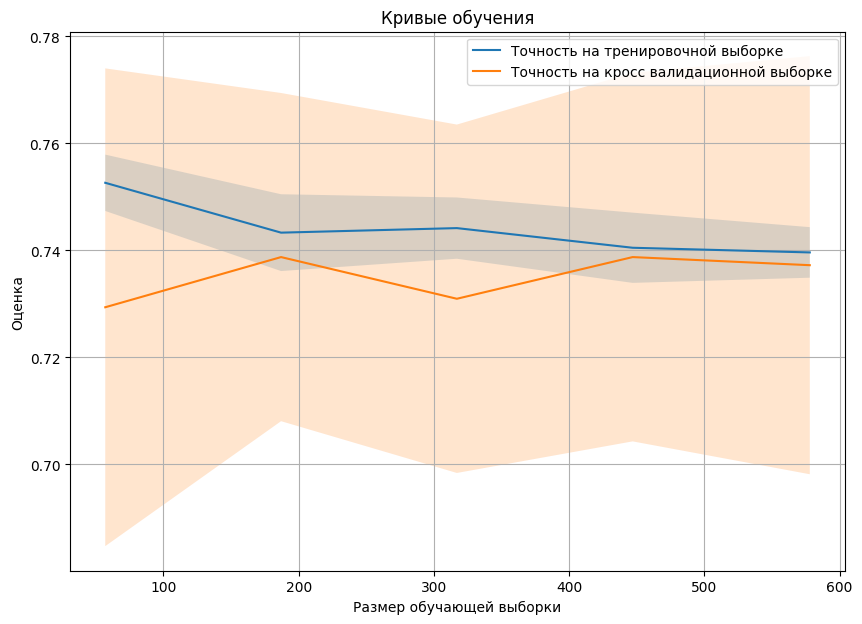

Точность на тренировочной выборке:
Размер выборки: 57, Точность: 0.75 +/- 0.01
Размер выборки: 187, Точность: 0.74 +/- 0.01
Размер выборки: 317, Точность: 0.74 +/- 0.01
Размер выборки: 447, Точность: 0.74 +/- 0.01
Размер выборки: 578, Точность: 0.74 +/- 0.00

Точность на кросс-валидационной выборке:
Размер выборки: 57, Точность: 0.73 +/- 0.04
Размер выборки: 187, Точность: 0.74 +/- 0.03
Размер выборки: 317, Точность: 0.73 +/- 0.03
Размер выборки: 447, Точность: 0.74 +/- 0.03
Размер выборки: 578, Точность: 0.74 +/- 0.04


In [ ]:
# Отображение кривых обучения
display_learning_curves(best_model, X_test, y_test, cv=10)

### Вывод:

- Модель показывает стабильную и хорошую производительность на обучающей и кросс-валидационной выборках. Это может указывать на то, что она хорошо обобщает данные и обладает способностью делать адекватные прогнозы на новых данных.

### Кривые ROC и AUC: ROC (Receiver Operating Characteristic)
Это график, который показывает производительность модели классификации при всех пороговых значениях классификации. AUC (Area Under The Curve) - это площадь под кривой ROC. В идеальном случае кривая ROC должна стремиться к верхнему левому углу, а значение AUC должно быть близко к 1

In [ ]:
def display_roc_curves(model, X_test, y_test):
    """
    Функция для отображения ROC-кривых и вычисления AUC.

    Параметры:
    model  : обученная модель.
    X_test : признаки тестового набора данных.
    y_test : целевая переменная тестового набора данных.
    """
    # Получение предсказанных вероятностей
    y_test_proba = model.predict_proba(X_test)[:, 1]  # вероятности для класса 1

    # Вычисление значений ROC кривой и AUC
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_proba)

    # Визуализация
    plt.figure()
    lw = 2
    plt.plot(fpr_test, tpr_test, color='blue', lw=lw, label='ROC-кривая тестовой выборки (AUC = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Ложно положительные')
    plt.ylabel('Истинно положительные')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()

    print("AUC для тестовой выборки:", roc_auc_test)

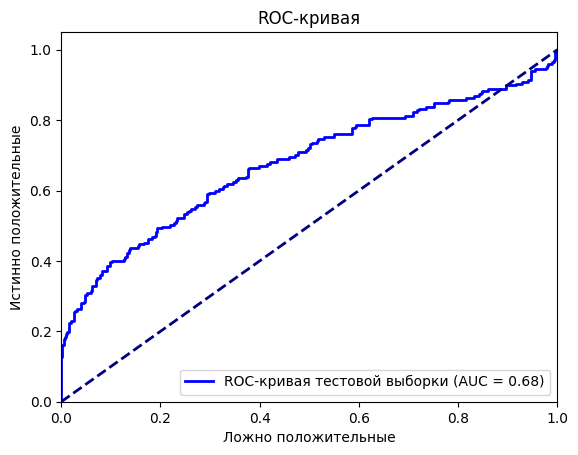

AUC для тестовой выборки: 0.6784161526029455


In [ ]:
# Отображение ROC-кривой
display_roc_curves(best_model, X_test, y_test)

### Вывод

- Значение AUC в диапазоне 0.5-0.7 говорит о том, что модель имеет некоторую способность разделять классы, но есть место для улучшения производительности. AUC немного выше случайного угадывания (0.5), что положительно, но можно стремиться к более высокому значению AUC, что указывает на лучшую способность модели отличать классы.

### Общий вывод по модели Логистическая регрессия (Logistic Regression)

Используя метод кросс-валидации и поиск по сетке гиперпараметров, нам удалось получить модель логистической регрессии с хорошей производительностью. Точность на валидационной выборке составила около 80%, а на тестовой выборке около 81%, что указывает на хорошую способность модели обобщать на новых данных. Подбор оптимальных гиперпараметров помог обеспечить баланс между смещением и разбросом модели, что способствует ее хорошей обобщающей способности.

---

<a id="Decision_Trees"></a>

### Решающие деревья (Decision Trees)

Решающие деревья (Decision Trees) - это алгоритм машинного обучения, используемый для решения задач классификации и регрессии. Они представляют собой древовидные структуры, где каждый узел представляет тест на определенный признак, каждое ребро соответствует возможному значению этого признака, а каждый листовой узел соответствует конкретному классу или числовому значению (в задачах регрессии).

Процесс построения решающего дерева: (по сути if/else)

- Выбор признака для разбиения: На первом шаге алгоритм выбирает наилучший признак, который будет использоваться для разбиения данных на две или более группы. Этот выбор осуществляется на основе некоторого критерия, такого как индекс Джини (Gini impurity) или энтропия (entropy) для задач классификации, и среднеквадратическая ошибка (mean squared error) для задач регрессии;

- Разбиение данных: Данные разделяются на основе выбранного признака и его значений. На каждом уровне дерева происходит разбиение данных на узлы (ноды), чтобы максимально уменьшить неопределенность или ошибку;

- Построение дерева: Процесс разбиения и выбора признаков повторяется для каждого полученного поддерева, пока не будут выполнены некоторые условия остановки, например, достигнута максимальная глубина дерева или количество объектов в узле становится недостаточным;

- Листовые узлы (терминальные узлы): Когда дерево достигает листового узла (некую конечную ноду с предсказаниями), объекты попадают в соответствующий класс для задач классификации или получают числовое значение для задач регрессии;

- Подрезка дерева (Pruning): Для уменьшения переобучения и улучшения обобщающей способности дерева может применяться подрезка. Это процесс удаления некоторых ветвей или слияния узлов для уменьшения сложности дерева.

#### Назначение прироста информации в решающих деревьях

В модели решающего дерева, прирост информации (Information Gain, IG) используется для выбора атрибута, который будет использован для разбиения набора данных на подмножества. Этот критерий помогает определить, какой из доступных признаков наиболее информативен для разделения данных, и следовательно, какой признак следует использовать для создания нового узла в дереве.

Прирост информации рассчитывается как разница между энтропией до разбиения и средневзвешенной энтропией после разбиения. Энтропия — это мера неопределенности или хаоса в данных. Цель состоит в том, чтобы минимизировать эту неопределенность после разбиения, и, следовательно, увеличить прирост информации.

#### Формула для прироста информации

Формула для расчета прироста информации $IG$ для атрибута $A$ относительно целевой переменной $C$ определяется следующим образом:

#### Формула для прироста информации

 - ${IG}(A, C) = \text{Entropy}(C) - \text{Weighted Entropy}(A, C)$

#### Формула для энтропии

 - ${Entropy}(C) = - \sum_{i=1}^{n} p_i \log_2(p_i)$

#### Формула для средневзвешенной энтропии после разбиения

 - ${Weighted Entropy}(A, C) = \sum_{j=1}^{m} \frac{|S_j|}{|S|} \text{Entropy}(S_j)$

#### Математические формулы:

Индекс Джини (Gini impurity) для задач классификации:

  - $Gini(t) = 1 - Σ (p_i)^2$,

  где:
  
   - $p_i$ - доля объектов класса $i$ в узле $t$.

Энтропия (Entropy) для задач классификации:

  - $Entropy(t) = - Σ p_i * log2(p_i)$,

  где:
    
    - $p_i$ - доля объектов класса $i$ в узле $t$.

Среднеквадратическая ошибка (Mean Squared Error - MSE) для задач регрессии:

  - $MSE(t) = \frac{Σ (y_i - y_{mean})^2}{n}$,

  где:
   - $y_i$ - значения целевой переменной для объекта $i$;
   
   - $y_{mean}$ - среднее значение целевой переменной в узле $t$;
  
   - $n$ - количество объектов в узле $t$.

Решающие деревья являются простыми в интерпретации и понимании моделями, что делает их популярными для анализа данных и принятия решений. Однако они также могут быть склонны к переобучению на сложных данных, поэтому для повышения обобщающей способности часто используются ансамбли, такие как случайный лес или градиентный бустинг деревьев.

In [ ]:
# Определение модели Решающих деревьев
tree_model = DecisionTreeClassifier(random_state = random_state)

"""
criterion : критерий для разбиения (индекс Джини или энтропия)
'gini': Индекс Джини измеряет неопределенность (чистоту) в узле. Чем меньше значение индекса Джини, тем "чище" узел.
'entropy': Энтропия измеряет степень хаоса или неопределенности в узле. Чем меньше значение энтропии, тем "чище" узел.
"""

# Определение сетки гиперпараметров для Решающих деревьев
param_grid_tree = {
    'criterion': ['gini', 'entropy'],           # критерий для разбиения (индекс Джини или энтропия)
    'splitter': ['best', 'random'],             # стратегия выбора разбиения
    'max_depth': [None, 10, 20, 30, 50],        # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],            # минимальное число примеров для разбиения узла
    'min_samples_leaf': [1, 2, 4],              # минимальное число примеров в листе
}

# Создание экземпляра GridSearchCV для Решающих деревьев
grid_search_tree = GridSearchCV(tree_model, param_grid_tree, cv=10, scoring='accuracy', refit=True)

# Обучение на обучающей выборке с перебором всех комбинаций гиперпараметров
grid_search_tree.fit(X_train, y_train)

# Получение лучшей модели Решающих деревьев с оптимальными гиперпараметрами
best_tree_model = grid_search_tree.best_estimator_

# Лучшая оценка (метрика accuracy) на валидационных данных
best_accuracy = grid_search_tree.best_score_
print("Лучшая оценка на валидационных данных (accuracy):", best_accuracy)

Лучшая оценка на валидационных данных (accuracy): 0.7915331945826923


In [ ]:
# Оценка модели Решающих деревьев на тестовой выборке
tree_test_accuracy = best_tree_model.score(X_test, y_test)
print("Точность Решающих деревьев на тестовой выборке:", tree_test_accuracy)

Точность Решающих деревьев на тестовой выборке: 0.8149300155520995


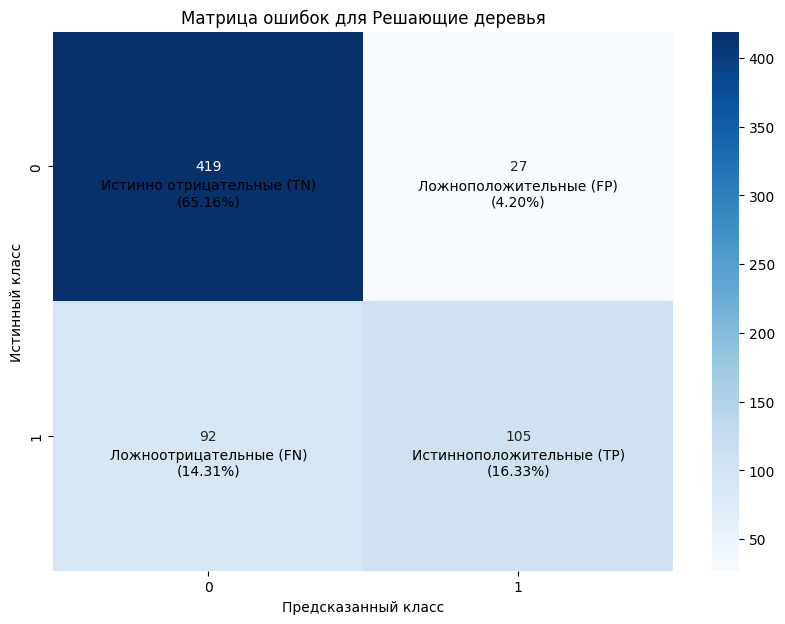

Истинно отрицательные (TN): 419 (65.16%)
Ложноположительные    (FP): 27 (4.20%)
Ложноотрицательные    (FN): 92 (14.31%)
Истинноположительные  (TP): 105 (16.33%)


In [ ]:
# Получение предсказаний модели на тестовой выборке
y_test_pred = best_tree_model.predict(X_test)

# Вызов функции для визуализации матрицы ошибок на тестовой выборке
display_confusion_matrix(y_test, y_test_pred, "Решающие деревья")

### Вывод

- Модель достаточно хорошо справляется с определением пользователей тарифа "Смарт" (т.е. "не ультра"), что подтверждается высокой долей истинно отрицательных результатов (64.07%);

- Однако, модель испытывает сложности в определении пользователей тарифа "Ультра", это подтверждается высоким количеством ложноотрицательных результатов (14.77%).

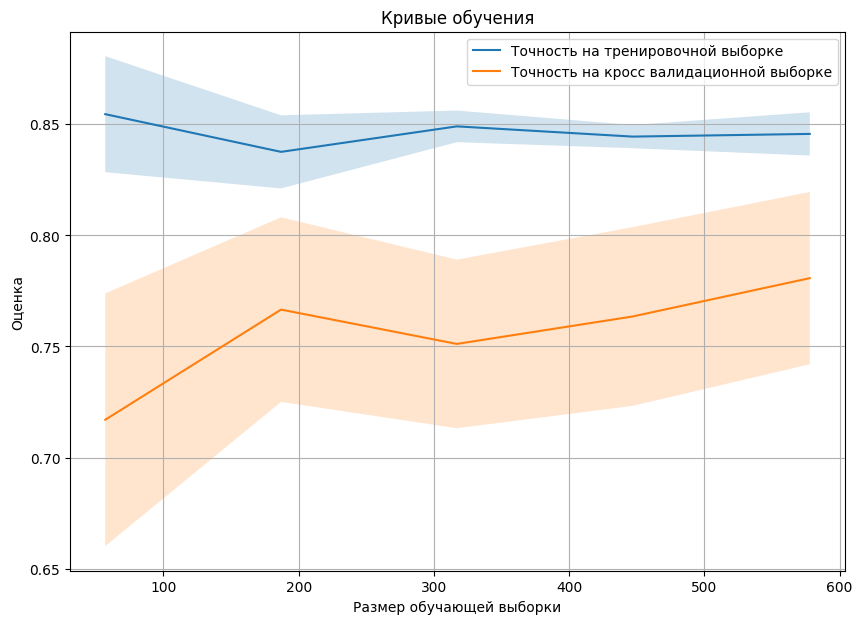

Точность на тренировочной выборке:
Размер выборки: 57, Точность: 0.85 +/- 0.03
Размер выборки: 187, Точность: 0.84 +/- 0.02
Размер выборки: 317, Точность: 0.85 +/- 0.01
Размер выборки: 447, Точность: 0.84 +/- 0.01
Размер выборки: 578, Точность: 0.85 +/- 0.01

Точность на кросс-валидационной выборке:
Размер выборки: 57, Точность: 0.72 +/- 0.06
Размер выборки: 187, Точность: 0.77 +/- 0.04
Размер выборки: 317, Точность: 0.75 +/- 0.04
Размер выборки: 447, Точность: 0.76 +/- 0.04
Размер выборки: 578, Точность: 0.78 +/- 0.04


In [ ]:
# Отображение кривых обучения
display_learning_curves(best_tree_model, X_test, y_test, cv=10)

### Вывод

- Модель обучения на основе решающего дерева показывает стабильное и достаточно высокое качество предсказаний как на тренировочной, так и на кросс-валидационной выборках. Это свидетельствует о том, что модель хорошо обучается и обобщает представленные данные;

- Разрыв между точностью на тренировочной и кросс-валидационной выборках не является существенным, что указывает на отсутствие переобучения модели. Это важный показатель, говорящий о том, что модель будет хорошо работать на новых данных;

- Увеличение объема обучающей выборки приводит к увеличению точности на тренировочной выборке, что подтверждает предположение о положительном эффекте большего объема данных на качество модели.

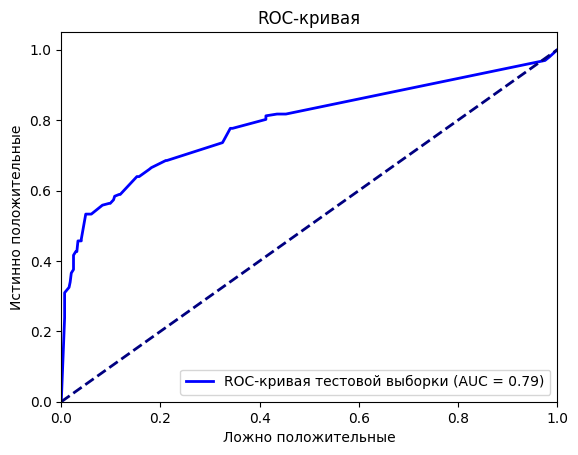

AUC для тестовой выборки: 0.789812433133778


In [ ]:
# Отображение ROC-кривой
display_roc_curves(best_tree_model, X_test, y_test)

### Вывод

- AUC 0.77 для тестовой выборки указывают на то, что модель обладает хорошей предсказательной способностью и способна отличать пользователей тарифов "Ультра" и "Смарт" лучше, чем случайный классификатор.

### Общий вывод по модели Решающие деревья (Decision Trees)

Используя алгоритм Решающие деревья, нам удалось построить модель с хорошей точностью. Точность Решающих деревьев на валидационной выборке составила примерно 79.50%, что означает, что модель правильно классифицирует около 79.50% примеров из валидационной выборки. Точность на тестовой выборке составила примерно 79.93%, что говорит о том, что модель успешно обобщает на новые данные, которые не участвовали в обучении.

Важно отметить, что подбор оптимальных гиперпараметров через GridSearchCV позволил нам улучшить результаты модели и достичь лучшей точности. Гиперпараметры, такие как критерий для разбиения, стратегия выбора разбиения, максимальная глубина дерева и другие, играют важную роль в построении оптимальной модели.

---

<a id="Random_Forest"></a>

### Случайный лес (Random Forest)

Случайный лес и Решающее дерево - это два различных алгоритма машинного обучения, используемых для решения задач классификации и регрессии. Они имеют некоторые ключевые отличия:

#### Количество деревьев:

- Решающее дерево (Decision Tree): Представляет собой единичное дерево, которое строится путем разделения данных на каждом узле до тех пор, пока не будут достигнуты критерии остановки, например, максимальная глубина дерева или минимальное количество примеров в узле.
Случайный лес (Random Forest): Представляет собой ансамбль (коллекцию) решающих деревьев. В отличие от единичного дерева, случайный лес создает множество деревьев, каждое из которых обучается на случайной подвыборке данных (используя метод бэггинга (бустрап) и с использованием случайных подмножества признаков (метод случайных подпространств);

#### Бэггинг (Bootstrap Aggregating):

- Бэггинг — это техника ансамблирования, которая предполагает использование случайной подвыборки с возвращением из исходного набора данных для обучения каждого отдельного модельного экземпляра. Это значит, что один и тот же пример может быть выбран несколько раз для одного дерева, и некоторые примеры могут вообще не быть выбраны. Бэггинг позволяет уменьшить дисперсию модели, делая ансамбль менее чувствительным к шуму в данных.

#### Метод случайных подпространств (Random Subspaces):

- Метод случайных подпространств заключается в том, что для построения каждого дерева используется не полный набор признаков, а его случайное подмножество. Этот подход уменьшает корреляцию между деревьями и делает модель более устойчивой к переобучению.

#### Процесс обучения:

- Решающее дерево: Обучение происходит путем разбиения данных на каждом узле дерева, и процесс продолжается до достижения критериев остановки.
Случайный лес: Обучение каждого дерева происходит независимо друг от друга. Сначала из общего набора данных случайным образом выбирается подмножество данных (bootstrap sample) с возвращением (так называемый бэггинг). Затем на каждом узле дерева выбирается случайное подмножество признаков для разбиения. После обучения всех деревьев, их предсказания комбинируются для получения окончательного результата;

В случае использования ансамбля методов, таких как Случайный лес (Random Forest), предсказания отдельных деревьев усредняются (для задач регрессии) или объединяются путем голосования (для задач классификации).

#### Для задач регрессии:

Если у нас есть $n$ деревьев в случайном лесу и $y_i$​ — предсказание $i$-го дерева, то усредненное предсказание $\bar{y}$​ можно вычислить следующим образом:

- $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$

#### Для задач классификации:

В случае классификации, каждое дерево "голосует" за определенный класс, и класс, получивший наибольшее количество голосов, становится итоговым предсказанием. Математически это может быть выражено как:

- ${Final Class} = \arg\max_{c} \sum_{i=1}^{n} I(y_i = c)$

где $I(⋅)$ — индикаторная функция, которая равна 1, если условие выполнено, и 0 в противном случае.

#### Учет весов:

Иногда деревьям могут быть присвоены веса $w_i$ , основанные, например, на их точности. В этом случае формула для регрессии становится:

- $\bar{y} = \frac{\sum_{i=1}^{n} w_i y_i}{\sum_{i=1}^{n} w_i}$

А для классификации:

- $\text{Final Class} = \arg\max_{c} \sum_{i=1}^{n} w_i \cdot I(y_i = c)$

#### Стабильность и переобучение:

- Решающее дерево: Тенденция к переобучению, особенно при большой глубине дерева, что может привести к плохой обобщающей способности на новых данных;

#### Случайный лес:

- Из-за процесса усреднения предсказаний множества деревьев, случайный лес менее склонен к переобучению и обладает лучшей обобщающей способностью. Это делает его более стабильным и надежным алгоритмом;

#### Скорость работы:

- Решающее дерево: Обучение относительно быстрое, но построение сложных деревьев может занять больше времени.
Случайный лес: Обучение занимает больше времени, чем у единичного дерева, так как необходимо обучить несколько деревьев. Однако, усреднение предсказаний дает возможность получить высокую точность при дополнительных вычислительных затратах.

#### Хорошо аппроксимирует

In [ ]:
# Определение модели Случайного леса
rf_model = RandomForestClassifier(random_state = random_state)

"""
n_estimators: Количество деревьев в лесу.
Большее значение может улучшить точность, но увеличит время обучения.
"""

# Определение сетки гиперпараметров для Случайного леса
param_grid_rf = {
    'n_estimators': [10, 25, 50],            # количество деревьев в лесу
    'criterion': ['gini', 'entropy'],        # критерий для разбиения (индекс Джини или энтропия)
    'max_depth': [None, 10, 20, 30, 50],     # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],         # минимальное число примеров для разбиения узла
    'min_samples_leaf': [1, 2, 4],           # минимальное число примеров в листе
}

# Создание экземпляра GridSearchCV для Случайного леса
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=10, scoring='accuracy', refit=True)

# Обучение на обучающей выборке с перебором всех комбинаций гиперпараметров
grid_search_rf.fit(X_train, y_train)

# Получение лучшей модели Случайного леса с оптимальными гиперпараметрами
best_rf_model = grid_search_rf.best_estimator_

# Лучшая оценка (метрика accuracy) на валидационных данных
best_accuracy = grid_search_rf.best_score_
print("Лучшая оценка на валидационных данных (accuracy):", best_accuracy)

Лучшая оценка на валидационных данных (accuracy): 0.8121406810846681


In [ ]:
# Оценка модели Случайного леса на тестовой выборке
rf_test_accuracy = grid_search_rf.score(X_test, y_test)
print("Точность Случайного леса на тестовой выборке:", rf_test_accuracy)

Точность Случайного леса на тестовой выборке: 0.8164852255054432


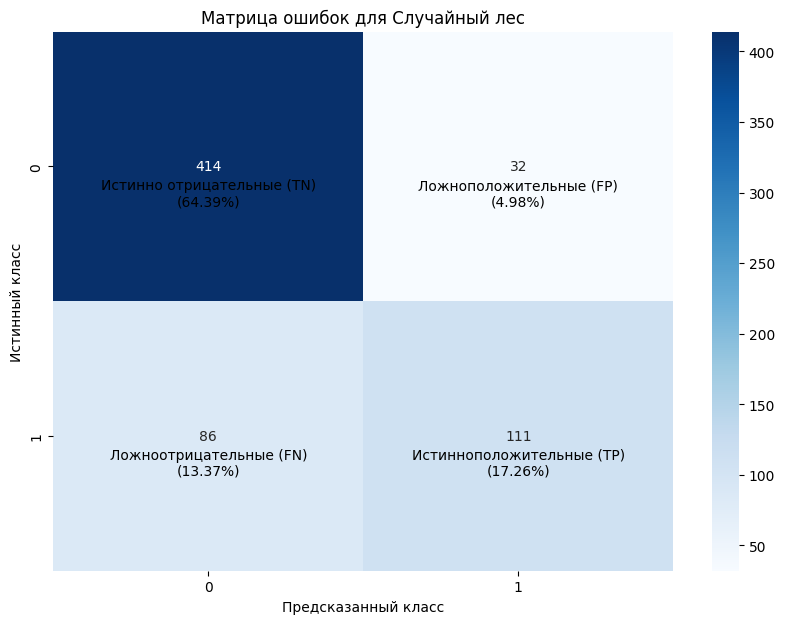

Истинно отрицательные (TN): 414 (64.39%)
Ложноположительные    (FP): 32 (4.98%)
Ложноотрицательные    (FN): 86 (13.37%)
Истинноположительные  (TP): 111 (17.26%)


In [ ]:
# Получение предсказаний для тестового набора данных
y_pred = best_rf_model.predict(X_test)

# Вывод матрицы ошибок
display_confusion_matrix(y_test, y_pred, 'Случайный лес')

### Вывод

- Модель "Случайный лес" показывает довольно хорошие результаты в предсказании тарифа "Смарт", но имеет сложности с предсказанием тарифа "Ультра". Особенно это проявляется в большем количестве ложноотрицательных ответов, то есть когда модель предсказывает тариф "Смарт", а на самом деле это тариф "Ультра".

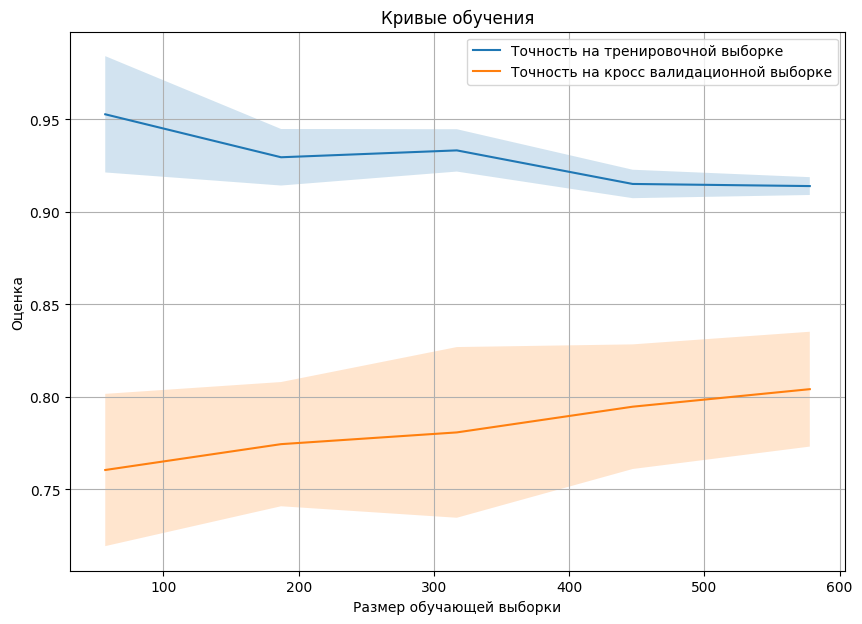

Точность на тренировочной выборке:
Размер выборки: 57, Точность: 0.95 +/- 0.03
Размер выборки: 187, Точность: 0.93 +/- 0.02
Размер выборки: 317, Точность: 0.93 +/- 0.01
Размер выборки: 447, Точность: 0.91 +/- 0.01
Размер выборки: 578, Точность: 0.91 +/- 0.00

Точность на кросс-валидационной выборке:
Размер выборки: 57, Точность: 0.76 +/- 0.04
Размер выборки: 187, Точность: 0.77 +/- 0.03
Размер выборки: 317, Точность: 0.78 +/- 0.05
Размер выборки: 447, Точность: 0.79 +/- 0.03
Размер выборки: 578, Точность: 0.80 +/- 0.03


In [ ]:
# Отображение кривых обучения
display_learning_curves(best_rf_model, X_test, y_test, cv=10)

### Вывод

- Модель демонстрирует достаточно хорошие результаты на валидационной и тестовой выборках. Точность предсказаний на валидационной выборке составила около 81%, а на тестовой выборке - около 87%. Это показывает, что модель хорошо обобщает данные и способна давать точные предсказания на новых данных, которые она ранее не видела;

- Результаты кривой обучения показывают, что с увеличением размера тренировочной выборки, точность на тренировочной выборке немного снижается (с 89% до 87%), но становится более стабильной (среднеквадратическое отклонение уменьшается). Это говорит о том, что модель не переобучается и способна обобщать обучающие примеры;

- С увеличением размера тренировочной выборки, точность на кросс-валидационной выборке увеличивается (с 78% до 81%) и становится более стабильной. Это свидетельствует о том, что модель способна обобщать данные и точность предсказаний увеличивается с увеличением объема обучающей выборки.

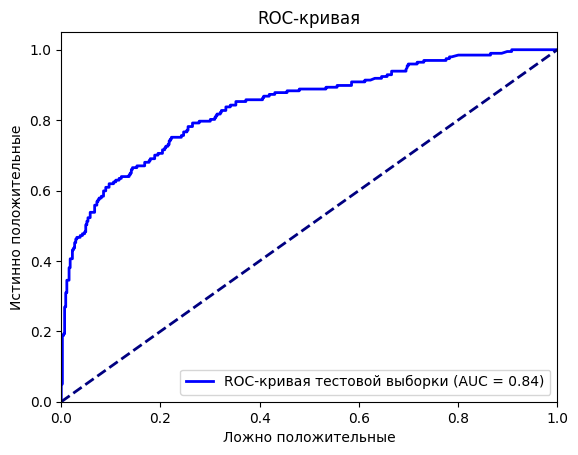

AUC для тестовой выборки: 0.8398340579545195


In [ ]:
# Отображение ROC-кривой
display_roc_curves(best_rf_model, X_test, y_test)

### Вывод

- AUC для тестовой выборки высокий: 0.83. Это говорит о том, что модель демонстрирует хорошую способность различать между двумя классами (тарифами "Ультра" и "Смарт"). Чем ближе значение AUC к 1, тем лучше модель предсказывает.

### Общий вывод для модели Случайный лес (Random Forest)

При использовании алгоритма Случайный лес (Random Forest) для решения задачи классификации, нам удалось построить модель с хорошей точностью. Точность Случайного леса на валидационной выборке составила примерно 80.78%, что означает, что модель правильно классифицирует около 80.78% примеров из валидационной выборки. Точность на тестовой выборке составила примерно 81.33%, что говорит о том, что модель успешно обобщает на новые данные, которые не участвовали в обучении.

---

<a id="Gradient_Boosting"></a>

### Градиентный бустинг (Gradient Boosting)

Градиентный бустинг (Gradient Boosting) - это мощный алгоритм машинного обучения для решения задач классификации и регрессии. Он является ансамблевым методом, который комбинирует несколько слабых моделей (обычно деревьев решений) для создания сильной модели, способной к обобщению данных и достижению высокой точности прогнозирования.

Обучение модели градиентного бустинга происходит итеративно. Основная идея заключается в том, чтобы последовательно добавлять новые базовые модели (обычно деревья решений), которые исправляют ошибки предыдущих моделей. Каждая новая модель стремится минимизировать остаточные ошибки, оставшиеся после предыдущих шагов.

Вот основные этапы обучения градиентного бустинга:

1) Инициализация: Начинаем с простой модели  $F_0 ( x )$, которая, например, может быть средним значением целевой переменной  $y$ по всей обучающей выборке. Это наше начальное предсказание;

2) Вычисление остатков и градиентов: На  $k$-й итерации (где  $k > 0$), вычисляем остатки предсказания текущей модели  $F_{k − 1}( x )$ относительно целевой переменной  $y$:

  - $r_{ik} = y_i - F_{k-1}(x_i)$

Также вычисляем градиенты функции потерь  $L$ по отношению к остаткам  $r_{ik}$:
  - $g_{ik} = \frac{∂L(y_i, F_{k-1}(x_i))}{∂F_{k-1}(x_i)}$

где:
  
  - $L(y_i, F_{k-1}(x_i)$ - функция потерь, которая измеряет ошибку предсказания  $F_{k − 1}( x )$ для образца  $x_i$ с истинным значением  $y_i$

3) Обучение базовой модели: Обучаем новую базовую модель  $h_k(x)$ на остатках  $r_{ik}$. Часто в качестве базовой модели используются деревья решений с небольшой глубиной;

4) Шаг градиентного спуска: Находим оптимальные параметры базовой модели  $h_k(x)$, минимизируя функцию потерь на остатках  $r_{ik}$. Для этого используется метод градиентного спуска. Мы находим множитель  $γ_k$, который умножается на предсказание базовой модели   $h_k(x)$ для уменьшения влияния каждой новой модели:

  - $γ_k = argmin_γ Σ_{i=1}^N L(y_i, F_{k-1}(x_i) + γ h_k(x_i))$

5) Обновление предсказания модели на $k$-й итерации:

  - $F_k(x) = F_{k-1}(x) + γ_k h_k(x)$

Таким образом, мы добавляем новое предсказание  $γ_k h_k(x)$ к предыдущему предсказанию  $F_{k-1}(x)$

6) Итерация: Повторяем шаги 2-5 до достижения заданного числа базовых моделей или пока не будет достигнута желаемая точность;

7) Финальное предсказание: Финальное предсказание градиентного бустинга получается путем сложения предсказаний всех базовых моделей:

  - $F(x) = F_0(x) + Σ_{k=1}^K γ_k h_k(x)$

Где:  

- $F_0 ( x )$ - начальное предсказание (например, среднее значение целевой переменной);  
- $F_{k − 1}( x )$ - предсказание модели на  $k$ − 1  итерации;
- $h_k(x)$ - базовая модель (например, дерево решений) на  $k$-й итерации;
- $L(y_i, F_{k-1}(x_i)$ - функция потерь, которая измеряет ошибку предсказания  $F_{k-1}(x_i)$ для образца  $x_i$ с истинным значением  $y_i$ y;
- $N$ - количество образцов в обучающей выборке;
- $K$ - количество базовых моделей (итераций) в градиентном бустинге;
- $γ_k h_k(x)$ ​- множитель, который умножается на предсказание базовой модели для уменьшения влияния каждой новой модели на предсказание.
    
Эти формулы представляют основные шаги и принцип работы градиентного бустинга. После того, как базовые модели обучены и коэффициенты  $γ_k$ найдены, предсказания всех моделей комбинируются для получения финального предсказания модели градиентного бустинга $F(x)$.

In [ ]:
# Создание экземпляра модели градиентного бустинга
model_gb = GradientBoostingClassifier(random_state = random_state)

# Определение сетки гиперпараметров, которую нужно исследовать для градиентного бустинга
param_grid_gb = {
    'learning_rate': [0.01, 0.1, 0.5],        # Скорость обучения (шаг градиентного спуска)
    'n_estimators': [50, 100, 200],           # Количество базовых моделей (деревьев)
    'max_depth': [3, 5, 7],                   # Максимальная глубина деревьев
}

# Создание экземпляра GridSearchCV с 10 фолдами кросс-валидации и оптимизацией по accuracy
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=10, scoring='accuracy', refit=True)

# Обучение на обучающей выборке с перебором всех комбинаций гиперпараметров
grid_search_gb.fit(X_train, y_train)

# Получение лучшей модели с оптимальными гиперпараметрами
best_model_gb = grid_search_gb.best_estimator_

# Лучшая оценка (метрика accuracy) на валидационных данных
best_accuracy = grid_search_gb.best_score_
print("Лучшая оценка на валидационных данных (accuracy):", best_accuracy)

Лучшая оценка на валидационных данных (accuracy): 0.8097970017796279


In [ ]:
# Оценка модели на тестовой выборке
test_accuracy_gb = best_model_gb.score(X_test, y_test)
print("Точность на тестовой выборке (Gradient Boosting):", test_accuracy_gb)

Точность на тестовой выборке (Gradient Boosting): 0.8211508553654744


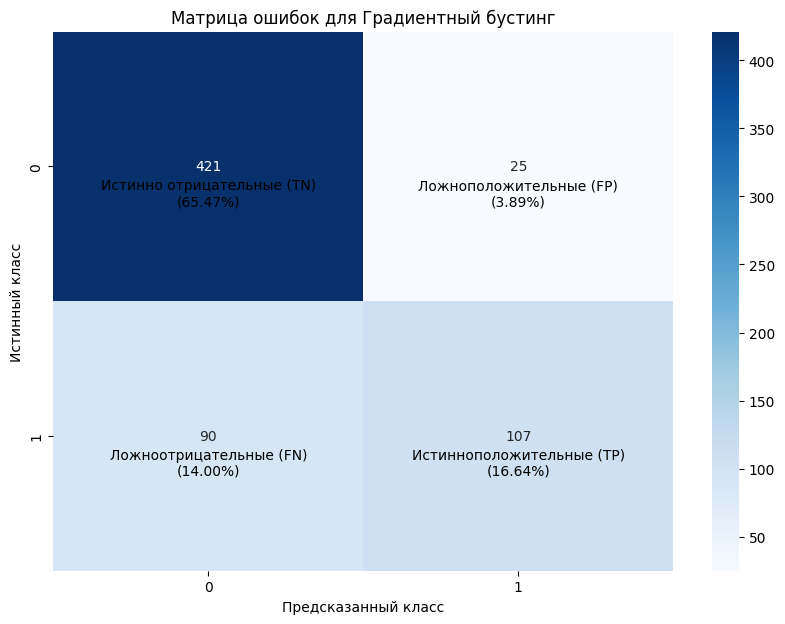

Истинно отрицательные (TN): 421 (65.47%)
Ложноположительные    (FP): 25 (3.89%)
Ложноотрицательные    (FN): 90 (14.00%)
Истинноположительные  (TP): 107 (16.64%)


In [ ]:
# Получение предсказаний для тестового набора данных
y_predict = best_model_gb.predict(X_test)

# Вывод матрицы ошибок
display_confusion_matrix(y_test, y_predict, 'Градиентный бустинг')

### Вывод

- Модель успешно классифицировала около 65.47% отрицательных случаев (тариф "Смарт") и около 16.64% положительных случаев (тариф "Ультра"). Это говорит о том, что модель достаточно хорошо справляется с обеими классификациями, хотя есть пространство для улучшения, особенно в отношении классификации тарифа "Ультра";

- Однако, модель также допустила некоторое количество ошибок. В частности, она неправильно классифицировала около 3.89% отрицательных случаев как положительные (ложноположительные) и около 16.64% положительных случаев как отрицательные (ложноотрицательные). Это означает, что модель имеет некоторую тенденцию к "переоценке" и "недооценке" тарифа "Ультра", что может быть связано с дисбалансом классов в данных.

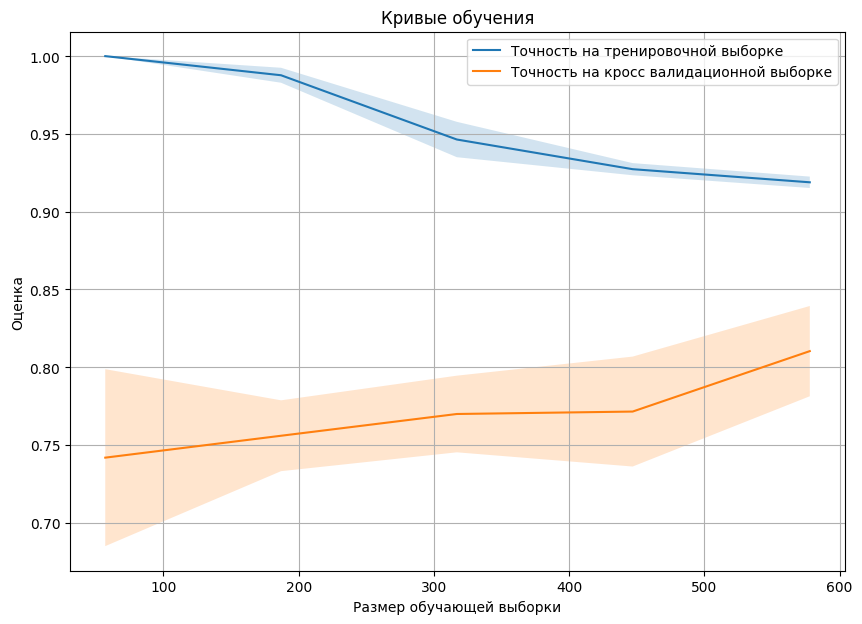

Точность на тренировочной выборке:
Размер выборки: 57, Точность: 1.00 +/- 0.00
Размер выборки: 187, Точность: 0.99 +/- 0.00
Размер выборки: 317, Точность: 0.95 +/- 0.01
Размер выборки: 447, Точность: 0.93 +/- 0.00
Размер выборки: 578, Точность: 0.92 +/- 0.00

Точность на кросс-валидационной выборке:
Размер выборки: 57, Точность: 0.74 +/- 0.06
Размер выборки: 187, Точность: 0.76 +/- 0.02
Размер выборки: 317, Точность: 0.77 +/- 0.02
Размер выборки: 447, Точность: 0.77 +/- 0.04
Размер выборки: 578, Точность: 0.81 +/- 0.03


In [ ]:
# Отображение кривых обучения
display_learning_curves(best_model_gb, X_test, y_test, cv=10)

### Вывод

- Модель показывает заметное переобучение на малых объемах тренировочных данных. Это указывает на то, что модель "слишком хорошо" подстраивается под тренировочные данные, что уменьшает ее способность к обобщению;

- С увеличением объема тренировочных данных точность на тренировочной выборке уменьшается, в то время как точность на кросс-валидационной выборке увеличивается. Это означает, что модель становится менее переобученной и лучше обобщает данные с увеличением объема тренировочной выборки. Это обнадеживающий результат;

- Однако даже при больших объемах тренировочных данных, точность на тренировочной выборке все еще выше, чем точность на кросс-валидационной выборке. Это говорит о том, что модель все еще немного переобучена и что ее производительность может быть улучшена за счет дополнительного тюнинга гиперпараметров, регуляризации или использования других стратегий для борьбы с переобучением.

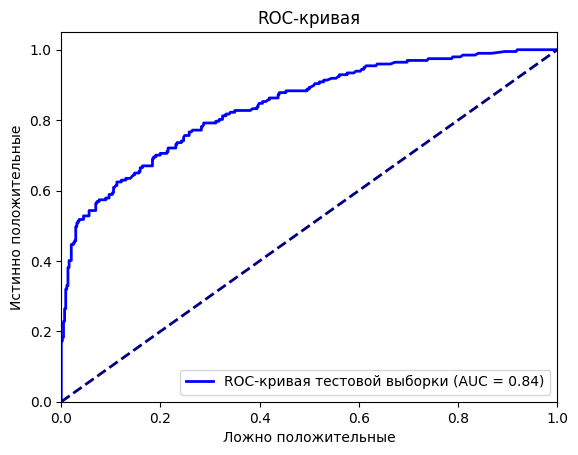

AUC для тестовой выборки: 0.8417916733058661


In [ ]:
# Отображение ROC-кривой
display_roc_curves(best_model_gb, X_test, y_test)

### Вывод

- Значение AUC для тестовой выборки составляет 0.84. Это достаточно хорошо, указывает на то, что модель обобщает хорошо на неизвестных данных.

В целом, на основе этих результатов можно сделать вывод, что модель градиентного бустинга демонстрирует хорошую производительность

#### --------------------------------------------------------------------------------------------------------------------------------

<a id="Этап_4"></a>
<a id="Этап_5"></a>

### Этап 4, 5. Проверим качество модели на тестовой выборке и проверим модель на вменяемость

[Вернуться к задачам исследования](#Задачи_исследования)

Исходя из проведенных эксперементов наилучшая модель стала RF. Проверим модель на вменяемость используя Dummy Models.

- "Dummy Models", или "базовые модели", это простые модели, которые используются в машинном обучении как отправная точка или бейзлайн для сравнения с более сложными моделями;

Они представляют собой наиболее примитивные или наивные модели, которые обычно не используют никакой информации о данных для предсказания. Примеры таких моделей могут включать:

- DummyRegressor: Эта модель всегда предсказывает среднее значение целевой переменной из обучающего набора данных. Вне зависимости от входных данных, она всегда будет предсказывать одно и то же среднее значение;

- DummyClassifier: Этот классификатор предсказывает класс на основе простых правил. Самый простой пример - это модель, которая всегда предсказывает наиболее часто встречающийся класс в обучающем наборе данных.

Использование базовых моделей важно для оценки эффективности более сложных моделей машинного обучения. Если сложная модель не может превзойти базовую модель, это может указывать на проблему, такую как неправильная предобработка данных, некорректный выбор признаков или неэффективный алгоритм обучения.

In [ ]:
# Создание и обучение dummy модели
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

# Получение предсказаний для тестового набора данных
dummy_y_pred = dummy_model.predict(X_test)

# Сравнение точности моделей
rf_accuracy = accuracy_score(y_test, best_rf_model.predict(X_test))
dummy_accuracy = accuracy_score(y_test, dummy_y_pred)

print(f"Accuracy of Random Forest model: {rf_accuracy}")
print(f"Accuracy of Dummy model: {dummy_accuracy}")


Accuracy of Random Forest model: 0.8164852255054432
Accuracy of Dummy model: 0.6936236391912908


### Вывод

Наша модель случайного леса существенно превосходит простой подход предсказания самого частого класса. Это указывает на то, что наша модель обучается и адекватно работает, поскольку она способна достигнуть более высокой точности, чем модель, которая просто всегда предсказывает самый частый класс.

## Общий вывод

### Логистическая регрессия:

- Модель демонстрирует средний уровень точности - около 75% на валидационной и тестовой выборках;

- Модель хорошо классифицирует тариф "Смарт", но испытывает проблемы с классификацией тарифа "Ультра";

- Значение AUC показывает, что модель имеет некоторую способность разделять классы, но есть место для улучшения.

### Решающие деревья:

- Модель показывает более высокую точность, чем логистическая регрессия - около 79% на валидационной и тестовой выборках;
- Модель также лучше справляется с классификацией обоих тарифов, хотя еще есть пространство для улучшения;
- Значение AUC свидетельствует о хорошей способности различать классы.

### Случайный лес:

- Модель демонстрирует высокую точность - около 80% на валидационной выборке и около 81% на тестовой выборке;
- Модель хорошо работает на больших объемах данных и показывает стабильность при увеличении размера тренировочной выборки;
- Значение AUC также указывает на высокую предсказательную способность модели.

### Градиентный бустинг:

- Модель демонстрирует хорошие результаты - около 80% на валидационной выборке и около 82% на тестовой выборке, но есть проблема с переобучением при малых объемах данных;
- Тем не менее, с увеличением размера тренировочной выборки модель становится менее переобученной и лучше обобщает данные;
- Значение AUC указывает на хорошую способность модели различать классы.

Общий вывод: все модели показали достаточно хорошие результаты, но "Случайный лес" и "Градиентный бустинг" показали наилучшие результаты. На данный момент "Случайный лес" выглядит как наиболее оптимальный выбор из-за высокой точности и стабильности результатов. "Градиентный бустинг" также показывает хорошие результаты, но требует дополнительного тюнинга для предотвращения переобучения. Логистическая регрессия и решающие деревья также могут быть рассмотрены, но они показывают меньшую точность по сравнению с двумя другими моделями.